In [1]:
#Overall Cyber Crime Category

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare

In [3]:
df = pd.read_csv('panel_data/cyber new.csv')
df['l_cyber'] = np.log(df['cyber_cr'] + 1)
df.head()

,s.no.,districts,year,type,cyber_crimes,pop_in_lak,cyber_cr,avg_temp,tot_rf,l_cyber
0,1,ariyalur,2011,cyber crime,0,7.52,0.0,28.312353,1103.207404,0.0
1,1,ariyalur,2012,cyber crimes,0,7.63,0.0,28.777312,973.207972,0.0
2,1,ariyalur,2013,cyber crime,0,7.76,0.0,28.730311,870.158045,0.0
3,1,ariyalur,2014,cyber crime,0,7.88,0.0,28.536042,1090.802339,0.0
4,1,ariyalur,2015,cyber crime,0,8.00,0.0,28.565911,1501.644532,0.0


In [4]:
df = df.set_index(['districts','year'])
y = df['l_cyber']
X = df[['avg_temp','tot_rf']]

In [5]:
#PooledOLS Estimation
X = sm.add_constant(X)
pols = PanelOLS(y,X)
pols_result = pols.fit()
print(pols_result.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                l_cyber   R-squared:                        0.0441
Estimator:                   PanelOLS   R-squared (Between):             -0.1054
No. Observations:                 384   R-squared (Within):               0.0628
Date:                Wed, Nov 12 2025   R-squared (Overall):              0.0441
Time:                        18:23:29   Log-likelihood                   -231.70
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.7810
Entities:                          32   P-value                           0.0002
Avg Obs:                       12.000   Distribution:                   F(2,381)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             8.7810
                            

In [6]:
#FE Model Estimation
X = sm.add_constant(X)
FEmodel = PanelOLS(y,X,entity_effects=True)
feresult = FEmodel.fit()
print(feresult.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                l_cyber   R-squared:                        0.1097
Estimator:                   PanelOLS   R-squared (Between):             -10.891
No. Observations:                 384   R-squared (Within):               0.1097
Date:                Wed, Nov 12 2025   R-squared (Overall):             -1.1178
Time:                        18:23:29   Log-likelihood                   -195.33
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      21.561
Entities:                          32   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(2,350)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             21.561
                            

In [7]:
#RE Model Estimation
from linearmodels.panel import RandomEffects
import statsmodels.api as sm
X = sm.add_constant(X)
REmodel = RandomEffects(y,X)
reresult = REmodel.fit()
print(reresult.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                l_cyber   R-squared:                        0.0520
Estimator:              RandomEffects   R-squared (Between):             -0.1568
No. Observations:                 384   R-squared (Within):               0.0679
Date:                Wed, Nov 12 2025   R-squared (Overall):              0.0428
Time:                        18:23:29   Log-likelihood                   -221.39
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.458
Entities:                          32   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(2,381)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             10.458
                            

In [8]:
#Hausman Test
from numpy.linalg import inv
from scipy.stats import chi2

b_FE = feresult.params
b_RE = reresult.params

common_coef = list(set(b_FE.index) & set(b_RE.index))

if 'const' in common_coef:
    common_coef.remove('const')

b_FE = b_FE[common_coef]
b_RE = b_RE[common_coef]

V_FE = feresult.cov
V_RE = reresult.cov

diff = b_FE - b_RE
diff_var = V_FE.loc[common_coef, common_coef] - V_RE.loc[common_coef, common_coef]

hausman_stat = np.dot(np.dot(diff.T, inv(diff_var)), diff)

df_h = len(diff)
p_value = 1 - chi2.cdf(hausman_stat, df_h)

print("Hausman Test Statistic:", round(hausman_stat, 3))
print("Degrees of Freedom:", df_h)
print("p-value:", round(p_value, 4))

Hausman Test Statistic: 23.427
Degrees of Freedom: 2
p-value: 0.0


In [9]:
#Diagnostic Checks
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson

In [10]:
#Test for Heteroskedasticity

#H0: No heteroskedasticity
#H1: Heteroskedasticity exists

#p-value <= 0.05 ---> Heteroskedasticity; p-value > 0.05 ---> Homoskedasticity

print('Breusch-Pagan Test')
residuals = feresult.resids
bp_test = het_breuschpagan(residuals, X)
bp_labels = ['Lagrange multiplier statistic','p-value','f-value','f p-value']
print(dict(zip(bp_labels, bp_test)))
print()
print('White Test')
white_test = het_white(residuals,X)
white_labels = ['LM stat','LM p-value','F p-value']
print(dict(zip(white_labels,white_test)))

Breusch-Pagan Test
{'Lagrange multiplier statistic': np.float64(5.423555035377646), 'p-value': np.float64(0.06641864141569061), 'f-value': np.float64(2.7291376628992072), 'f p-value': np.float64(0.06655189051757221)}

White Test
{'LM stat': np.float64(15.07649151978812), 'LM p-value': np.float64(0.010040453054451835), 'F p-value': np.float64(3.089482596518018)}


In [11]:
#Test for serial correlation (autocorrelation)

#Durbin-Watson statistic ranges between 0 to 4

#DW statistic = 2 ---> No autocorrelation
#DW statistic < 2 ---> Positive autocorrelation
#DW statistic > 2 ---> Negative autocorrelation

print('Durbin-Watson Test')
dw_value = durbin_watson(residuals)
print("Durbin-Watson statistic: ", round(dw_value,3))

Durbin-Watson Test
Durbin-Watson statistic:  1.514


In [12]:
from scipy import stats

#Test for cross-section dependency

#H0: No cross-section dependency
#H1: Cross-section dependency exists

print('Breusch-Pagan LM Test')
resid_df = residuals.unstack(level=0)
T = resid_df.shape[0]
N = resid_df.shape[1]

rho = resid_df.corr().values
upper_tri_idx = np.triu_indices(N, k=1)
rho_upper = rho[upper_tri_idx]
LM_stat = T * np.sum(rho_upper**2)
p_value = 1 - stats.chi2.cdf(LM_stat, N*(N-1)/2)

print(f"Breusch-Pagan LM statistic: {LM_stat:.3f}")
print(f"p-value: {p_value:.4f}")
print()

print('Pesaran CD Test')
CD_stat = np.sqrt(2 / (N*(N-1))) * np.sum(rho_upper)
p_value_cd = 2 * (1 - stats.norm.cdf(abs(CD_stat)))

print(f"Pesaran CD statistic: {CD_stat:.3f}")
print(f"p-value: {p_value_cd:.4f}")

Breusch-Pagan LM Test
Breusch-Pagan LM statistic: 2311.733
p-value: 0.0000

Pearson CD Test
Pesaran CD statistic: 12.098
p-value: 0.0000


In [13]:
#Re-estimate FE Model

In [14]:
#FE with cov.type 'clustered'
fe_model_robust1 = FEmodel.fit(cov_type='clustered', cluster_entity=True)
print(fe_model_robust1.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                l_cyber   R-squared:                        0.1097
Estimator:                   PanelOLS   R-squared (Between):             -10.891
No. Observations:                 384   R-squared (Within):               0.1097
Date:                Wed, Nov 12 2025   R-squared (Overall):             -1.1178
Time:                        18:23:29   Log-likelihood                   -195.33
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      21.561
Entities:                          32   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(2,350)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             18.245
                            

In [15]:
#FE with cov.type 'kernel' (Driscoll-Kraay Method)
fe_model_robust2 = FEmodel.fit(cov_type='kernel')
print(fe_model_robust2.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                l_cyber   R-squared:                        0.1097
Estimator:                   PanelOLS   R-squared (Between):             -10.891
No. Observations:                 384   R-squared (Within):               0.1097
Date:                Wed, Nov 12 2025   R-squared (Overall):             -1.1178
Time:                        18:23:29   Log-likelihood                   -195.33
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      21.561
Entities:                          32   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(2,350)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             5.9750
                            

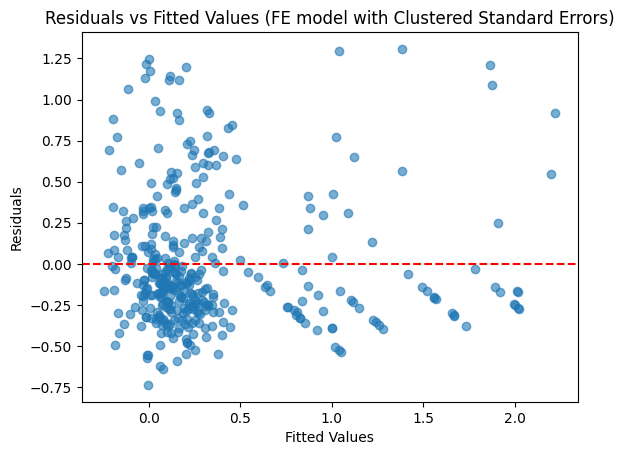

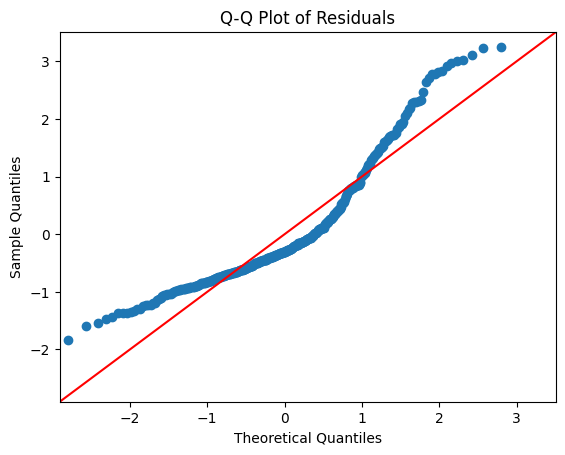

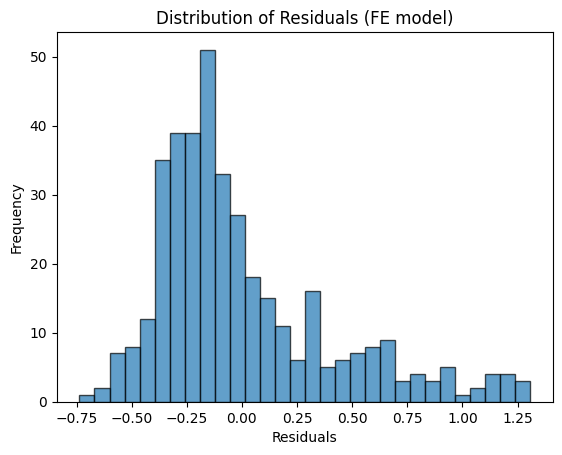

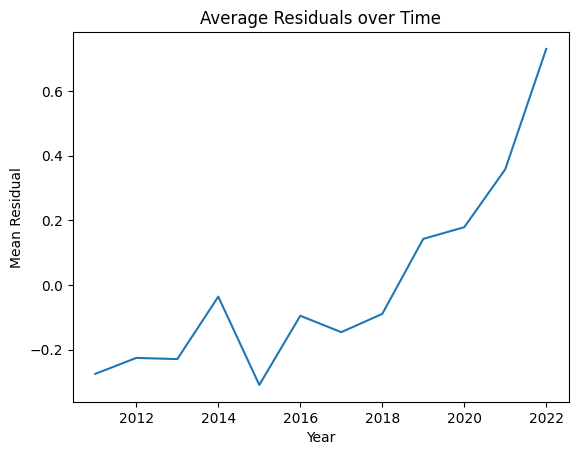

Shapiro-Wilk Test: Statistic=0.887, p-value=0.0000


In [16]:
# Check residuals and fitted values
df['residuals1'] = fe_model_robust1.resids
df['fitted1'] = fe_model_robust1.fitted_values

import matplotlib.pyplot as plt

plt.scatter(df['fitted1'], df['residuals1'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (FE model with Clustered Standard Errors)')
plt.show()

sm.qqplot(df['residuals1'], line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.hist(df['residuals1'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (FE model)')
plt.show()

resid_df = df['residuals1'].unstack(level=0)
plt.plot(resid_df.mean(axis=1))
plt.title('Average Residuals over Time')
plt.xlabel('Year')
plt.ylabel('Mean Residual')
plt.show()

from scipy.stats import shapiro

#Test for normality

stat, p = shapiro(df['residuals1'])
print(f"Shapiro-Wilk Test: Statistic={stat:.3f}, p-value={p:.4f}")

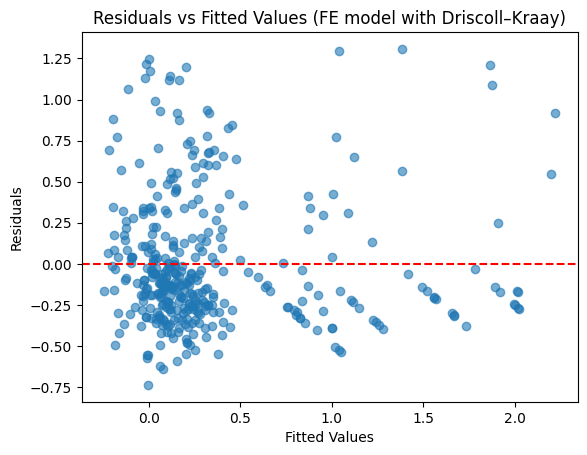

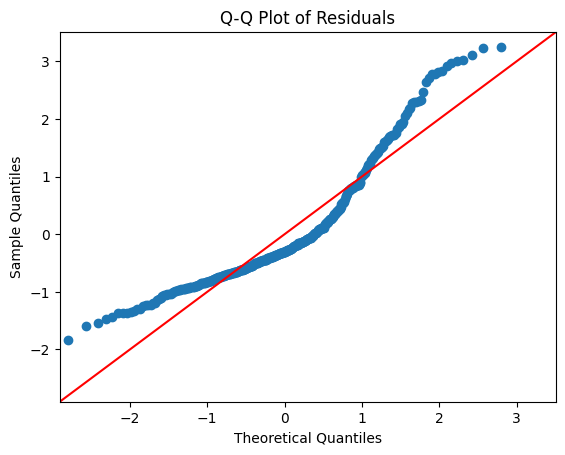

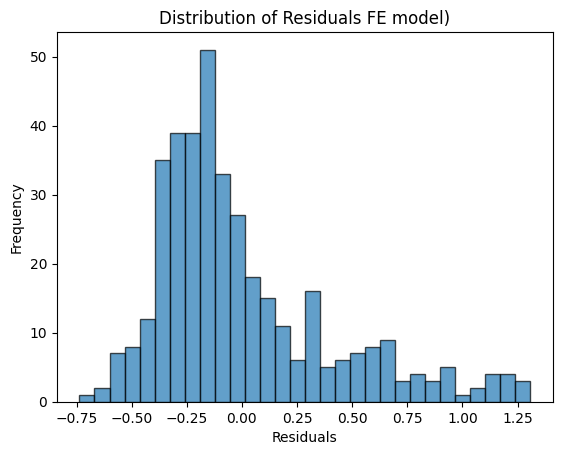

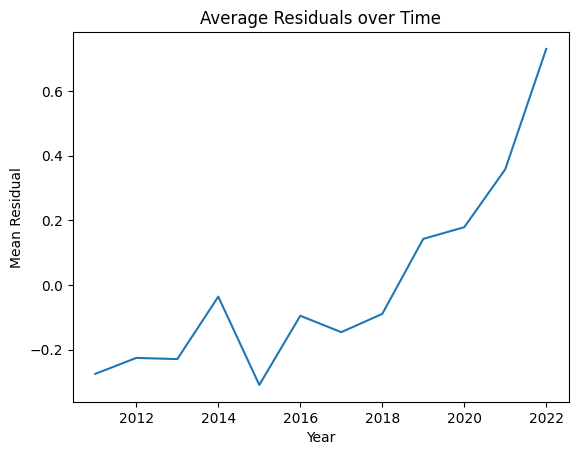

Shapiro-Wilk Test: Statistic=0.887, p-value=0.0000


In [17]:
# Check residuals and fitted values
df['residuals2'] = fe_model_robust2.resids
df['fitted2'] = fe_model_robust2.fitted_values

import matplotlib.pyplot as plt

plt.scatter(df['fitted2'], df['residuals2'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (FE model with Driscoll–Kraay)')
plt.show()

sm.qqplot(df['residuals2'], line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

plt.hist(df['residuals2'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals FE model)')
plt.show()

resid_df = df['residuals2'].unstack(level=0)
plt.plot(resid_df.mean(axis=1))
plt.title('Average Residuals over Time')
plt.xlabel('Year')
plt.ylabel('Mean Residual')
plt.show()

from scipy.stats import shapiro

#Test for normality

stat, p = shapiro(df['residuals2'])
print(f"Shapiro-Wilk Test: Statistic={stat:.3f}, p-value={p:.4f}")